In [1]:
!pip install opencv-python tensorflow scikit-learn matplotlib seaborn pandas

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [8]:
DATASET_DIR = r"C:\Users\KIIT\Downloads\BloodCellDetection\BloodCellDetection\blood cell images dataset\bloodcells_dataset"

classes = os.listdir(DATASET_DIR)
print("Detected Classes:", classes)


Detected Classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


In [9]:
for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    print(f"{cls}: {len(os.listdir(folder))} images")


basophil: 1218 images
eosinophil: 3117 images
erythroblast: 1551 images
ig: 2895 images
lymphocyte: 1214 images
monocyte: 1420 images
neutrophil: 3329 images
platelet: 2348 images


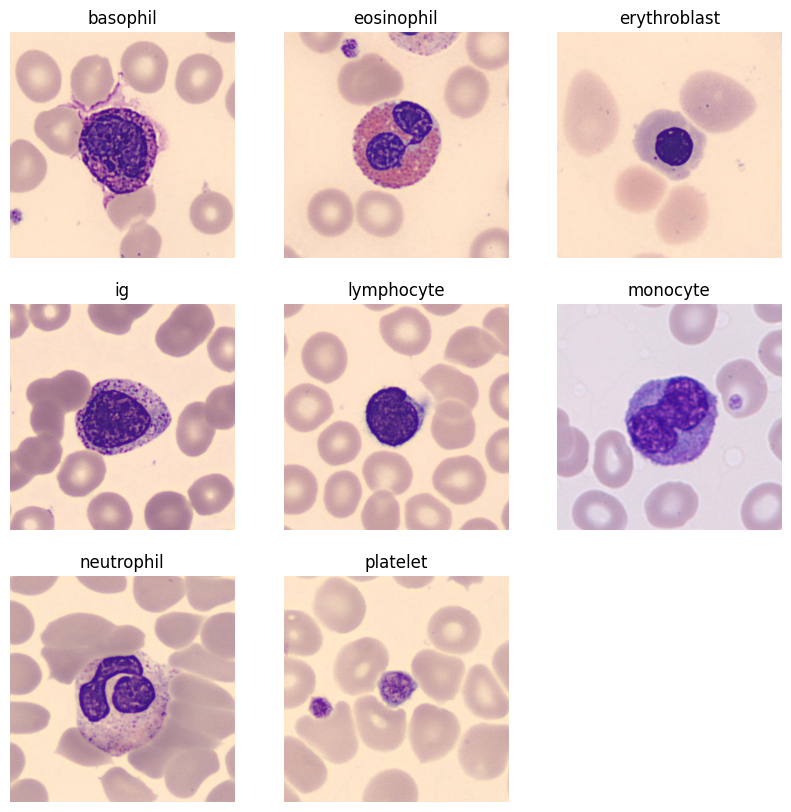

In [21]:
import random
import cv2

plt.figure(figsize=(10, 10))
i = 1
for cls in classes[:9]:
    folder = os.path.join(DATASET_DIR, cls)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
    i += 1
plt.show()


Found 17092 files belonging to 8 classes.
Classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


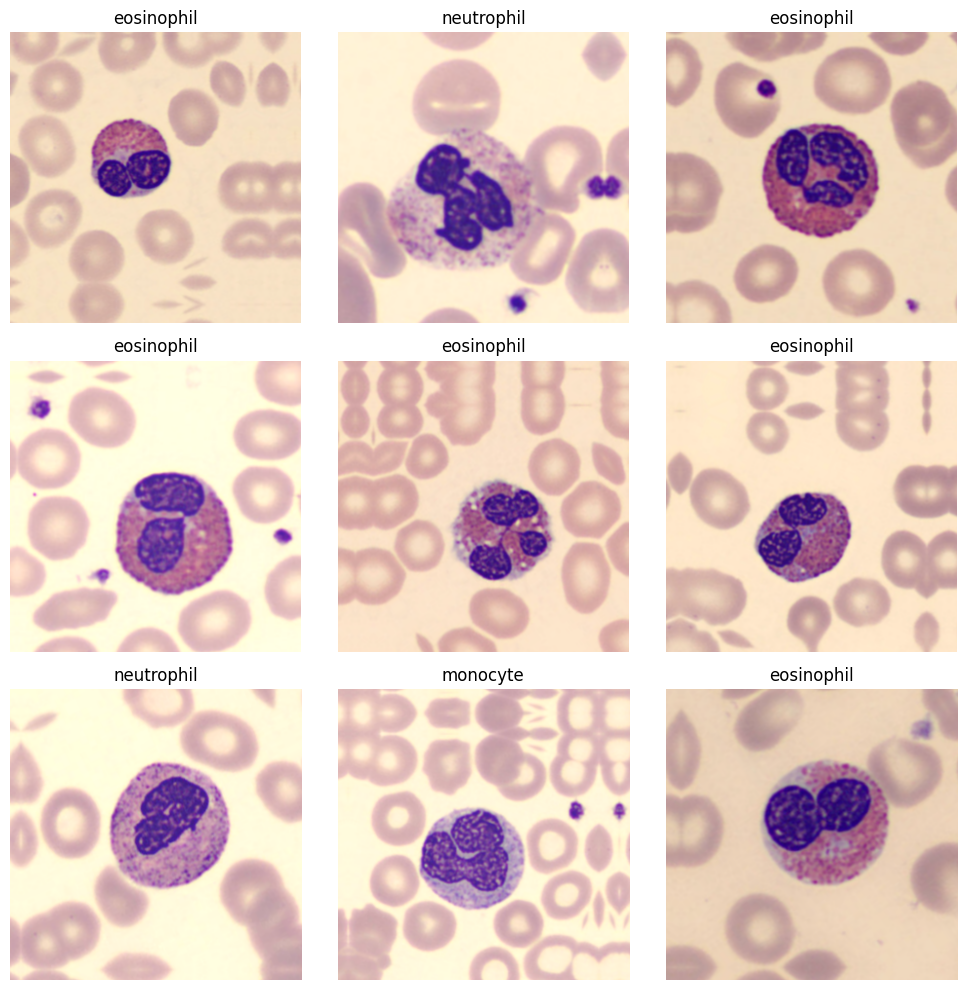

In [29]:
BATCH_SIZE = 16
IMG_SIZE = (299, 299)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
class_names = train_ds.class_names
print("Classes:", class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
import matplotlib.pyplot as plt
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
], name="data_augmentation")

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0), training=True)
        img_to_show = tf.clip_by_value(augmented_image[0], 0, 255)
        plt.imshow(img_to_show.numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [26]:
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    folder = os.path.join(DATASET_DIR, cls)
    imgs = [os.path.join(folder, i) for i in os.listdir(folder)]
    image_paths.extend(imgs)
    labels.extend([idx] * len(imgs))

image_paths = np.array(image_paths)
labels = np.array(labels)

balanced_paths = []
balanced_labels = []

for cls_id in range(len(classes)):
    cls_paths = image_paths[labels == cls_id]
    max_count = max([sum(labels == i) for i in range(len(classes))])

    cls_upsampled = resample(cls_paths, replace=True, n_samples=max_count)
    balanced_paths.extend(cls_upsampled)
    balanced_labels.extend([cls_id] * max_count)

balanced_paths = np.array(balanced_paths)
balanced_labels = np.array(balanced_labels)

print("Balanced dataset size:", len(balanced_paths))


Balanced dataset size: 26632


In [27]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, y_train, y_test = train_test_split(
    balanced_paths, balanced_labels, test_size=0.2, random_state=42, stratify=balanced_labels
)

In [30]:
train_df = pd.DataFrame({
    "filename": train_paths,
    "class": y_train
})

test_df = pd.DataFrame({
    "filename": test_paths,
    "class": y_test
})

print("Train samples:", len(train_df))
print("Test samples:", len(test_df))

print(train_df.head())

Train samples: 21305
Test samples: 5327
                                            filename  class
0  C:\Users\KIIT\Downloads\BloodCellDetection\Blo...      4
1  C:\Users\KIIT\Downloads\BloodCellDetection\Blo...      0
2  C:\Users\KIIT\Downloads\BloodCellDetection\Blo...      4
3  C:\Users\KIIT\Downloads\BloodCellDetection\Blo...      6
4  C:\Users\KIIT\Downloads\BloodCellDetection\Blo...      5


In [37]:
def augment_and_preprocess(img):
    img = tf.expand_dims(img, 0)
    img = data_augmentation(img, training=True)
    img = tf.squeeze(img, 0)
    img = preprocess_input(img)
    return img

train_aug = ImageDataGenerator(preprocessing_function=augment_and_preprocess)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="class",
    target_size=(299, 299),
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="class",
    target_size=(299, 299),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

STEP_PER_EPOCH = train_gen.samples // train_gen.batch_size
VALID_STEPS = test_gen.samples // test_gen.batch_size


Found 21305 validated image filenames belonging to 8 classes.
Found 5327 validated image filenames belonging to 8 classes.


In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
NUM_CLASSES = len(classes)
CHECKPOINT_PATH = r"C:\Users\KIIT\Downloads\BloodCellDetection\BloodCellDetection\checkpoint.keras"
FINAL_MODEL_PATH = r"C:\Users\KIIT\Downloads\BloodCellDetection\BloodCellDetection\final_trained_model.keras"
if os.path.exists(CHECKPOINT_PATH):
    print("Resuming from checkpoint...")
    model = load_model(CHECKPOINT_PATH)
else:
    print("Creating new model...")
    base = InceptionV3(
        weights="imagenet",
        include_top=False,
        input_shape=(299, 299, 3)
    )
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)
    output = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs=base.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()
checkpoint = ModelCheckpoint(
    CHECKPOINT_PATH,
    monitor="val_loss",
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
print("\n Starting Stage 1 Training (Base Frozen)…")
history1 = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=25,
    callbacks=[checkpoint, early_stop]
)
print("\n Unfreezing last 50 layers for fine-tuning…")
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[-50:]:
    layer.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
print("\n Starting Stage 2 Fine-Tuning Training…")
history2 = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)
model.save(FINAL_MODEL_PATH)
print("\n FINAL MODEL SAVED AT:", FINAL_MODEL_PATH)

Creating new model...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_285 (Conv2D)           │ (None, 149, 149, 32)      │             864 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_284       │ (None, 149, 149, 32)      │              96 │ conv2d_285[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_282 (Activation)   │ (None, 149, 149, 32)      │               0 │ batch_normalization_284[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_286 (Conv2D)           │ (None, 147, 147, 32)      │           9,216 │ activation_282[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_285       │ (None, 147, 147, 32)      │              96 │ conv2d_286[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_283 (Activation)   │ (None, 147, 147, 32)      │               0 │ batch_normalization_285[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_287 (Conv2D)           │ (None, 147, 147, 64)      │          18,432 │ activation_283[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_286       │ (None, 147, 147, 64)      │             192 │ conv2d_287[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_284 (Activation)   │ (None, 147, 147, 64)      │               0 │ batch_normalization_286[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_15              │ (None, 73, 73, 64)        │               0 │ activation_284[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_288 (Conv2D)           │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d_15[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_287       │ (None, 73, 73, 80)        │             240 │ conv2d_288[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_285 (Activation)   │ (None, 73, 73, 80)        │               0 │ batch_normalization_287[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_289 (Conv2D)           │ (None, 71, 71, 192)       │         138,24

 Total params: 22,337,576 (85.21 MB)

 Trainable params: 530,696 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)


 Starting Stage 1 Training (Base Frozen)…
Epoch 1/25
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 74s/step - accuracy: 0.5262 - loss: 1.4069  
Epoch 1: saving model to C:\Users\KIIT\Downloads\BloodCellDetection\BloodCellDetection\checkpoint.keras
666/666 ━━━━━━━━━━━━━━━━━━━━ 52839s 79s/step - accuracy: 0.6559 - loss: 1.0062 - val_accuracy: 0.8408 - val_loss: 0.4666
Epoch 2/25
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.7862 - loss: 0.6205 
Epoch 2: saving model to C:\Users\KIIT\Downloads\BloodCellDetection\BloodCellDetection\checkpoint.keras
666/666 ━━━━━━━━━━━━━━━━━━━━ 14732s 22s/step - accuracy: 0.8000 - loss: 0.5793 - val_accuracy: 0.8780 - val_loss: 0.3602
Epoch 3/25
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8297 - loss: 0.5018 
Epoch 3: saving model to C:\Users\KIIT\Downloads\BloodCellDetection\BloodCellDetection\checkpoint.keras
666/666 ━━━━━━━━━━━━━━━━━━━━ 11563s 17s/step - accuracy: 0.8351 - loss: 0.4875 - val_accuracy: 0.8941 - val_loss: 0.3160
Epoch 4/25
666/666 ━